In [1]:
SEED = 839
# Data splits containing only the largest 5 sites
SPLITS='./nested_kfolds_24mo_5sites.pkl' 
FEATURE = 'ADAS11_bl'

In [2]:
import sys
import numpy as np
import pandas as pd
import scipy.stats
import tqdm
import json
import pickle

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from statsmodels.stats import multitest
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

import tensorflow as tf
import tensorflow.keras.layers as tkl
from tensorflow_probability import layers as tpl
from tensorflow_probability.python.layers.util import default_mean_field_normal_fn
from tensorflow_probability import distributions as tpd

sys.path.append('../')
from medl.metrics import classification_metrics

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

Limit GPU usage to device #1 and cap memory allocation.

In [15]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = InteractiveSession(config=config)

tf.config.get_visible_devices()

/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Load pre-made nested K-folds

In [5]:
# Original dataset
dfData = pd.read_csv('../data/adni/baseline_features_24mo_imputeddx.csv', index_col=0)
dfTarget = pd.read_csv('../data/adni/target_24mo_imputeddx.csv', index_col=0)

# Splits
with open(SPLITS, 'rb') as f:
    lsFolds = pickle.load(f)

# Traditional binomial mixed-effects GLM

In [7]:
class MixedGLMClassifier:
    def __init__(self, feature_name, site_name='SITE'):
        self.strFeature = feature_name
        self.strSite = site_name

        self.strFormula = f'CONVERSION ~ {feature_name}'
        self.dictRandomEffects = {'site_slope': f'0 + C({site_name}):{feature_name}'}
        self.model = None

    def fit(self, dfX):       
        self.model = BinomialBayesMixedGLM.from_formula(self.strFormula, self.dictRandomEffects, dfX)
        self.fit_result = self.model.fit_vb()

    def predict(self, dfX):
        if self.model is None:
            raise UserWarning('Model has not been fit yet.')

        dfRE = self.fit_result.random_effects()

        lsRESlopes = [dfRE['Mean'].filter(like=str(x)).values[0] for x in dfX[self.strSite]]
        arrRESlopes = np.array(lsRESlopes)
        arrRandomEffects = arrRESlopes * dfX[self.strFeature].values

        arrDesignMat = np.ones((dfX.shape[0], 2))
        arrDesignMat[:, 1] = dfX[self.strFeature]

        arrPredFE = self.fit_result.predict(arrDesignMat, linear=True)
        arrPredMixed = arrPredFE + arrRandomEffects

        arrPredMixedLogit = self.model.family.link.inverse(arrPredMixed)

        return arrPredMixedLogit



Note: this model performs much worse when the input is standard scaled (0M1V) vs. min-max scaled or un-scaled. 

In [76]:
dfVariables = dfData[[FEATURE, 'SITE']].copy()
dfVariables['CONVERSION'] = dfTarget
dfVariables.dropna(inplace=True)

# Loop through each inner fold
lsInnerFolds = lsFolds[0]['inner']

lsMetricsTrain = []
lsMetricsVal = []

for iFold, tupSplits in enumerate(lsInnerFolds[:1]):
    dfDataTrain, dfSiteTrain, dfTargetTrain, dfDataVal, dfSiteVal, dfTargetVal = tupSplits

    dfVariablesTrain = dfVariables.loc[dfDataTrain.index]
    dfVariablesVal = dfVariables.loc[dfDataVal.index]

    preproc = Pipeline([('scaler', MinMaxScaler()), ('imputer', SimpleImputer())])
    # preproc = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer())])
    dfVariablesTrain[FEATURE] = preproc.fit_transform(dfVariablesTrain[FEATURE].values.reshape(-1, 1))
    dfVariablesVal[FEATURE] = preproc.transform(dfVariablesVal[FEATURE].values.reshape(-1, 1))

    mglm = MixedGLMClassifier(FEATURE)
    mglm.fit(dfVariablesTrain)
    arrPredTrain = mglm.predict(dfVariablesTrain)
    dictMetricsTrain, youdenTrain = classification_metrics(dfVariablesTrain['CONVERSION'], arrPredTrain)

    arrPredVal = mglm.predict(dfVariablesVal)
    dictMetricsVal, _ = classification_metrics(dfVariablesVal['CONVERSION'], arrPredVal, youdenTrain)

    lsMetricsTrain += [dictMetricsTrain]
    lsMetricsVal += [dictMetricsVal]

dfMetricsTrain = pd.DataFrame(lsMetricsTrain)
dfMetricsVal = pd.DataFrame(lsMetricsVal)
dfMetrics = pd.concat([dfMetricsTrain, dfMetricsVal], keys=['Train', 'Val'], axis=1)

dfMetrics.mean()

Train  AUROC             0.964561
       Accuracy          0.913580
       Youden's index    0.852851
       F1                0.857143
       PPV               0.777778
       NPV               0.981481
       Sensitivity       0.954545
       Specificity       0.898305
Val    AUROC             0.822222
       Accuracy          0.809524
       Youden's index    0.533333
       F1                0.666667
       PPV               0.666667
       NPV               0.866667
       Sensitivity       0.666667
       Specificity       0.866667
dtype: float64

In [77]:
mglm.fit_result.random_effects()

,Mean,SD
C(SITE)[23]:ADAS11_bl,10.070584,1.944729
C(SITE)[27]:ADAS11_bl,7.550683,1.645539
C(SITE)[72]:ADAS11_bl,2.963276,1.650518
C(SITE)[128]:ADAS11_bl,-3.513304,4.464873
C(SITE)[137]:ADAS11_bl,5.703544,1.876808


In [78]:
mglm.fit_result.random_effects().std()

Mean    5.204471
SD      1.208384
dtype: float64

In [79]:
mglm.fit_result.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,-3.7465,0.3280,,,
ADAS11_bl,M,2.5517,0.8319,,,
site_slope,V,1.8556,0.2607,6.395,3.797,10.773


# Mixed-effects neural network

In [34]:
class MixedFFNN:
    def __init__(self, n_sites, prior_scale=1.0, post_mean_init_scale=0.5, 
                 post_scale_init_min=1.0, post_scale_init_range=0.5, kl_weight=0.01):
        self.prior_scale = prior_scale
        self.post_mean_init_scale = post_mean_init_scale
        self.post_scale_init_min = post_scale_init_min
        self.post_scale_init_range = post_scale_init_range
        
        inputX = tkl.Input((1,), name='input')
        inputZ = tkl.Input((n_sites,), name='input_z')

        denseFE = tkl.Dense(1, 
                            kernel_initializer='he_normal', 
                            name='dense_fe')(inputX)                     

        re_posterior_fn = self.make_re_posterior_fn()
        re_prior_fn = self.make_re_prior_fn()
        denseRESlope = tpl.DenseVariational(1, re_posterior_fn, re_prior_fn, use_bias=False,
                                            kl_weight=tf.keras.backend.cast_to_floatx(kl_weight),
                                            name='re_slope')(inputZ)
    
        output = tkl.Activation('sigmoid')(denseFE + denseRESlope * inputX)

        self.model = tf.keras.Model((inputX, inputZ), output)

        # output = tkl.Activation('sigmoid')(denseFE)
        # self.model = tf.keras.Model(inputX, output)

        self.model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=[tf.keras.metrics.AUC(name='auc'),
                            tf.keras.metrics.Precision(name='ppv')]
                    )

        
    def make_re_posterior_fn(self):
        # Compute inverse softplus
        fPostScaleMin = np.log(np.exp(self.post_scale_init_min) - 1)
        fPostScaleRange = np.log(np.exp(self.post_scale_init_range) - 1)

        fPostMeanInitScale = tf.keras.backend.cast_to_floatx(self.post_mean_init_scale)
        fPostScaleMin = tf.keras.backend.cast_to_floatx(fPostScaleMin)
        fPostScaleRange = tf.keras.backend.cast_to_floatx(fPostScaleRange)

        def _posterior_fn(kernel_size, bias_size=0, dtype=None):
            n= kernel_size + bias_size
            # There are n variables containing the mean of each weight and n variables containing the shared s.d. for all weights
            initializer = tpl.BlockwiseInitializer([tf.keras.initializers.RandomNormal(mean=0., stddev=fPostMeanInitScale), 
                                                    tf.keras.initializers.RandomUniform(minval=fPostScaleMin, 
                                                                                        maxval=fPostScaleMin + fPostScaleRange),
                                                    ],
                                                    sizes=[n, n])

            return tf.keras.Sequential([tpl.VariableLayer(n + n, dtype=dtype, initializer=initializer),
                                        tpl.DistributionLambda(lambda t: tpd.Independent(
                                            tpd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(t[..., n:])),
                                        reinterpreted_batch_ndims=1))
                                    ])
        return _posterior_fn


    def make_re_prior_fn(self):
        fPriorScale = tf.keras.backend.cast_to_floatx(self.prior_scale)

        def _prior_fn(kernel_size, bias_size=0, dtype=None):  
            n = kernel_size + bias_size
            # Fixed scale prior
            return tf.keras.Sequential([tpl.DistributionLambda(lambda t: tpd.Normal(loc=0, scale=fPriorScale))])
            # initializer = tf.keras.initializers.Constant(-2)
            # return tf.keras.Sequential([tpl.VariableLayer(1, dtype=dtype, initializer=initializer),
            #                             tpl.DistributionLambda(lambda t: 
            #                             tpd.Normal(loc=tf.zeros(n), scale=1e-5 + tf.nn.softplus(t)))])
        return _prior_fn

    def predict(self, x, z, n=100):
        arrPred = np.zeros((x.shape[0], n))
        for i in range(n):
            arrPred[:, i] = self.model.predict((x, z), verbose=0).squeeze()

        return arrPred


In [37]:
# Custom early stopping that uses the mean of several performance estimates instead of a single estimate
class MultiSampleEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, val_inputs, val_labels, **kwargs):
        self.val_inputs = val_inputs
        self.val_labels = val_labels
        self.lr_dropped = False

        super(MultiSampleEarlyStopping, self).__init__(**kwargs)

    def on_epoch_end(self, epoch, logs=None):
        n = 10
        lsMetrics = []
        for i in range(n):
            lsMetrics += [self.model.evaluate(self.val_inputs, self.val_labels, verbose=0, return_dict=True)]

        dictLogs = pd.DataFrame(lsMetrics).mean(axis=0).to_dict()

        super(MultiSampleEarlyStopping, self).on_epoch_end(epoch, dictLogs)

        if (dictLogs[self.monitor] > 0.8) & (self.lr_dropped == False):
            lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
            lr *= 0.1
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
            print(f'Learning rate set to {lr:.05f}')
            self.lr_dropped = True

        

In [96]:
# Loop through each inner fold
lsInnerFolds = lsFolds[0]['inner']

lsMetricsTrain = []
lsMetricsVal = []

for iFold, tupSplits in enumerate(lsInnerFolds):
    dfDataTrain, dfSiteTrain, dfTargetTrain, dfDataVal, dfSiteVal, dfTargetVal = tupSplits

    preproc = Pipeline([('scaler', MinMaxScaler()), ('imputer', SimpleImputer())])
    arrDataTrainScaled = preproc.fit_transform(dfDataTrain[FEATURE].values.reshape(-1, 1))
    arrDataValScaled = preproc.transform(dfDataVal[FEATURE].values.reshape(-1, 1))

    tf.random.set_seed(SEED)
    
    # Construct model
    menn = MixedFFNN(dfSiteTrain.shape[1], prior_scale=2.336, post_mean_init_scale=0.371, 
                 post_scale_init_min=0.1, post_scale_init_range=0, kl_weight=0.03)

    # earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=20, 
    #                                              restore_best_weights=True)
    earlystop = MultiSampleEarlyStopping((arrDataValScaled, dfSiteVal), dfTargetVal, 
                                         monitor='auc', mode='max', patience=50, 
                                         restore_best_weights=True)
        
    # Weight for non-converter class (n_converters / (n_nonconverters))
    fNegWeight = dfTargetTrain.values.sum() / (1 - dfTargetTrain.values).sum() 
                                        
    menn.model.fit((arrDataTrainScaled, dfSiteTrain), dfTargetTrain, 
            validation_data=((arrDataValScaled, dfSiteVal), dfTargetVal),
            callbacks=[earlystop],
            batch_size=32,
            epochs=500,
            class_weight={0.: fNegWeight, 1.: 1.},
            verbose=1)

    arrPredTrain = menn.predict(arrDataTrainScaled, dfSiteTrain)
    arrPredVal = menn.predict(arrDataValScaled, dfSiteVal)

    dictTrainMetrics, fYoudenTrain = classification_metrics(dfTargetTrain.values.squeeze(), arrPredTrain.mean(axis=1))
    dictValMetrics, _ = classification_metrics(dfTargetVal.values.squeeze(), arrPredVal.mean(axis=1), fYoudenTrain)

    lsMetricsTrain += [dictTrainMetrics]
    lsMetricsVal += [dictValMetrics]

dfMetricsTrain = pd.DataFrame(lsMetricsTrain)
dfMetricsVal = pd.DataFrame(lsMetricsVal)
dfMetrics = pd.concat([dfMetricsTrain, dfMetricsVal], keys=['Train', 'Val'], axis=1)

dfMetrics.mean()

<ipython-input-34-850ef1b8f564>:39: RuntimeWarning: divide by zero encountered in log
  fPostScaleRange = np.log(np.exp(self.post_scale_init_range) - 1)
Epoch 1/500
3/3 [==============================] - 1s 252ms/step - loss: 8.2945 - auc: 0.3667 - ppv: 0.3889 - val_loss: 8.8013 - val_auc: 0.5556 - val_ppv: 0.0000e+00
Epoch 2/500
3/3 [==============================] - 0s 104ms/step - loss: 8.2296 - auc: 0.3848 - ppv: 1.0000 - val_loss: 8.4149 - val_auc: 0.6111 - val_ppv: 0.0000e+00
Epoch 3/500
3/3 [==============================] - 0s 100ms/step - loss: 8.3027 - auc: 0.3975 - ppv: 1.0000 - val_loss: 8.7397 - val_auc: 0.6222 - val_ppv: 0.0000e+00
Epoch 4/500
3/3 [==============================] - 0s 87ms/step - loss: 8.1408 - auc: 0.4230 - ppv: 0.0000e+00 - val_loss: 8.2389 - val_auc: 0.6056 - val_ppv: 0.0000e+00
Epoch 5/500
3/3 [==============================] - 0s 101ms/step - loss: 8.3231 - auc: 0.4206 - ppv: 0.0000e+00 - val_loss: 8.9494 - val_auc: 0.6111 - val_ppv: 0.0000e+00
Epoch

Train  AUROC             0.925960
       Accuracy          0.865041
       Youden's index    0.769532
       F1                0.791717
       PPV               0.691915
       NPV               0.969004
       Sensitivity       0.928458
       Specificity       0.841073
Val    AUROC             0.930905
       Accuracy          0.842857
       Youden's index    0.698095
       F1                0.747179
       PPV               0.666667
       NPV               0.941758
       Sensitivity       0.860000
       Specificity       0.838095
dtype: float64

In [97]:
arrREWeights = menn.model.get_layer('re_slope').weights[0].numpy()
arrREPostMean = arrREWeights[:5]
arrREPostSd = tf.math.softplus(arrREWeights[5:]).numpy()
print('Posterior mean', arrREPostMean)
print('Posterior s.d.', arrREPostSd)

Posterior mean [ 0.6682915   0.30775872  0.02581049 -0.18813463  0.09027854]
Posterior s.d. [0. 0. 0. 0. 0.]


In [98]:
print('FE weight', menn.model.get_layer('dense_fe').weights[0].numpy())
print('FE bias', menn.model.get_layer('dense_fe').bias[0].numpy())

FE weight [[0.25427458]]
FE bias -0.8365593


In [86]:
nModels = 50
np.random.seed(SEED)
dfRandomSearch = pd.DataFrame({'prior_scale': np.random.uniform(0.1, 3., size=nModels),
                               'post_mean_init_scale': np.random.uniform(0.05, 1.0, size=nModels),
                               'post_scale_init_min': np.random.uniform(0.1, 1.0, size=nModels),
                               'post_scale_init_range': np.random.uniform(0.5, 1, size=nModels),
                               'kl_weight': np.random.uniform(1e-4, 3e-2, size=nModels),
                               'train_acc_mean': None,
                               'train_acc_sd': None,
                               'val_acc_mean': None,
                               'val_acc_sd': None,
                               'train_f1_mean': None,
                               'train_f1_sd': None,
                               'val_f1_mean': None,
                               'val_f1_sd': None,
                               'train_sens_mean': None,
                               'train_sens_sd': None,
                               'val_sens_mean': None,
                               'val_sens_sd': None})

for iModel in tqdm.tqdm(range(nModels), total=nModels):
    row = dfRandomSearch.loc[iModel]
    dictConfig = row[['prior_scale', 'post_mean_init_scale', 'post_scale_init_min', 'post_scale_init_range', 'kl_weight']].to_dict()

    lsMetricsTrain = []
    lsMetricsVal = []

    for iFold, tupSplits in enumerate(lsInnerFolds):
        dfDataTrain, dfSiteTrain, dfTargetTrain, dfDataVal, dfSiteVal, dfTargetVal = tupSplits

        preproc = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer())])
        arrDataTrainScaled = preproc.fit_transform(dfDataTrain[FEATURE].values.reshape(-1, 1))
        arrDataValScaled = preproc.transform(dfDataVal[FEATURE].values.reshape(-1, 1))

        tf.random.set_seed(SEED)
        
        # Construct model
        menn = MixedFFNN(dfSiteTrain.shape[1], **dictConfig)
        
        earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=20, 
                                                    restore_best_weights=True)
            
        # Weight for non-converter class (n_converters / (n_nonconverters))
        fNegWeight = dfTargetTrain.values.sum() / (1 - dfTargetTrain.values).sum() 
                                            
        menn.model.fit((arrDataTrainScaled, dfSiteTrain), dfTargetTrain, 
                validation_data=((arrDataValScaled, dfSiteVal), dfTargetVal),
                callbacks=[earlystop],
                batch_size=32,
                epochs=500,
                class_weight={0.: fNegWeight, 1.: 1.},
                verbose=0)

        arrPredTrain = menn.predict(arrDataTrainScaled, dfSiteTrain)
        arrPredVal = menn.predict(arrDataValScaled, dfSiteVal)

        dictTrainMetrics, fYoudenTrain = classification_metrics(dfTargetTrain.values.squeeze(), arrPredTrain.mean(axis=1))
        dictValMetrics, _ = classification_metrics(dfTargetVal.values.squeeze(), arrPredVal.mean(axis=1), fYoudenTrain)

        lsMetricsTrain += [dictTrainMetrics]
        lsMetricsVal += [dictValMetrics]

    dfMetricsTrain = pd.DataFrame(lsMetricsTrain)
    dfMetricsVal = pd.DataFrame(lsMetricsVal)

    dfRandomSearch.loc[iModel, ['train_acc_mean', 'train_acc_sd', 'train_f1_mean', 'train_f1_sd',
                    'train_sens_mean', 'train_sens_sd']] = [dfMetricsTrain['Accuracy'].mean(), 
                                                            dfMetricsTrain['Accuracy'].std(), 
                                                            dfMetricsTrain['F1'].mean(), 
                                                            dfMetricsTrain['F1'].std(), 
                                                            dfMetricsTrain['Sensitivity'].mean(), 
                                                            dfMetricsTrain['Sensitivity'].std()]

    dfRandomSearch.loc[iModel, ['val_acc_mean', 'val_acc_sd', 'val_f1_mean', 'val_f1_sd',
                    'val_sens_mean', 'val_sens_sd']] = [dfMetricsVal['Accuracy'].mean(), 
                                                        dfMetricsVal['Accuracy'].std(), 
                                                        dfMetricsVal['F1'].mean(), 
                                                        dfMetricsVal['F1'].std(), 
                                                        dfMetricsVal['Sensitivity'].mean(), 
                                                        dfMetricsVal['Sensitivity'].std()]


 10%|█         | 5/50 [05:47<51:10, 68.23s/it]/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 12%|█▏        | 6/50 [06:52<49:14, 67.15s/it]/project/bioinformatics/DLLab/shared/CondaEnvironments/Kevin385Ray/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no 

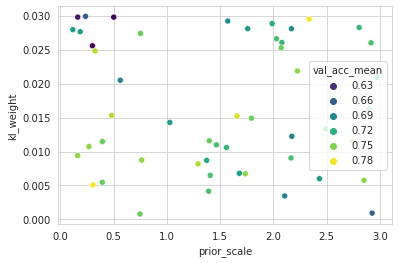

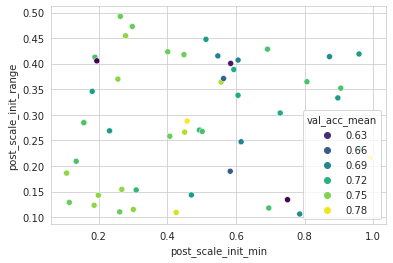

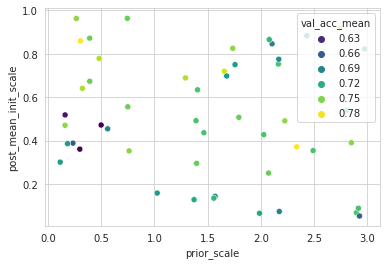

In [87]:
sns.scatterplot(data=dfRandomSearch, x='prior_scale', y='kl_weight', hue='val_acc_mean', palette='viridis')
plt.show()
sns.scatterplot(data=dfRandomSearch, x='post_scale_init_min', y='post_scale_init_range', hue='val_acc_mean', palette='viridis')
plt.show()
sns.scatterplot(data=dfRandomSearch, x='prior_scale', y='post_mean_init_scale', hue='val_acc_mean', palette='viridis')
plt.show()

<AxesSubplot:xlabel='post_scale_init_min', ylabel='post_scale_init_range'>

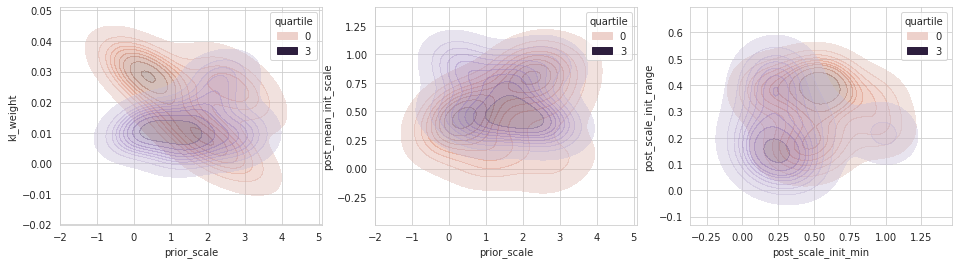

In [92]:
dfQuartiles = pd.qcut(dfRandomSearch['val_f1_mean'], 4, labels=False)
dfRandomSearchBottom = dfRandomSearch.loc[dfQuartiles == 1]
dfRandomSearchTop = dfRandomSearch.loc[dfQuartiles == 4]

dfRandomSearchPlot = dfRandomSearch.copy()
dfRandomSearchPlot['quartile'] = dfQuartiles

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.kdeplot(data=dfRandomSearchPlot.loc[dfQuartiles.isin([0, 3])], x='prior_scale', y='kl_weight', ax=ax[0], fill=True, hue='quartile', alpha=0.4)
sns.kdeplot(data=dfRandomSearchPlot.loc[dfQuartiles.isin([0, 3])], x='prior_scale', y='post_mean_init_scale', ax=ax[1], fill=True, hue='quartile', alpha=0.4)
sns.kdeplot(data=dfRandomSearchPlot.loc[dfQuartiles.isin([0, 3])], x='post_scale_init_min', y='post_scale_init_range', ax=ax[2], fill=True, hue='quartile', alpha=0.4)

In [91]:
dfRandomSearch.sort_values('val_f1_mean', ascending=False).head()

,prior_scale,post_mean_init_scale,post_scale_init_min,post_scale_init_range,kl_weight,train_acc_mean,train_acc_sd,val_acc_mean,val_acc_sd,train_f1_mean,train_f1_sd,val_f1_mean,val_f1_sd,train_sens_mean,train_sens_sd,val_sens_mean,val_sens_sd
14,2.335834,0.370858,0.993474,0.216298,0.029505,0.799097,0.0377866,0.78381,0.102483,0.704022,0.0354149,0.676117,0.156943,0.864822,0.0656888,0.82,0.184992
8,0.480997,0.778753,0.157981,0.285207,0.015330,0.808823,0.0253465,0.763333,0.11533,0.717804,0.0296135,0.664078,0.13668,0.88419,0.0500082,0.813333,0.142595
45,2.849890,0.389938,0.255663,0.370026,0.005756,0.803945,0.0354357,0.753333,0.107863,0.717596,0.0376243,0.661481,0.135296,0.901581,0.0385603,0.853333,0.164317
31,0.762821,0.352225,0.300590,0.115248,0.008742,0.794158,0.0397107,0.753333,0.107863,0.70998,0.0370475,0.661481,0.135296,0.910277,0.04598,0.853333,0.164317
3,1.657319,0.719525,0.425448,0.109391,0.015231,0.803945,0.0384548,0.773333,0.09202,0.713624,0.034344,0.658974,0.131871,0.883004,0.0530551,0.786667,0.15741
